In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import optuna
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [3]:
df.head(5)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,boiling_point_K
0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,...,14,12,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13,0.9,390.81
1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,...,6,4,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2,-0.1,351.44
2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,...,2,1,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2,-0.5,337.85
3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,Training,100.25,...,10,8,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7,0.3,370.35
4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,NaN,NaN,...,30,31,2.361111,1.666667,NaN,118.17,no alternative,42,2.7,384.62


Text(0, 0.5, 'Data Count')

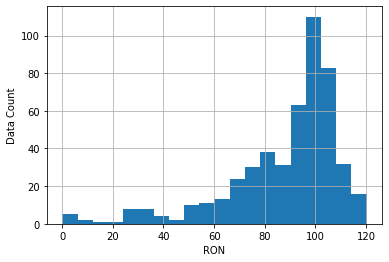

In [4]:
df['y'].hist(bins=20)
plt.xlabel('RON')
plt.ylabel('Data Count')

#### Remove ouliers later on 

In [5]:
df.shape

(492, 894)

In [6]:
misssing_val_cols = df.columns[df.isnull().any()]
print('Columns with missing values are = {}'.format(list(misssing_val_cols)))

'''Columns which have no influence on prediction'''
irrelevant_to_pred_columns = ['PubChem','ron_choice','SMILES']


df_ = df.drop(misssing_val_cols,axis=1)
df_ = df_.drop(irrelevant_to_pred_columns,axis=1)

df_x = df_.drop('y',axis=1)
df_y = df['y']

Columns with missing values are = ['Compound Name', 'TARGET', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON', 'dev', 'boiling_point_K']


In [7]:
#### Split dataset for 'unbiased model assesment'

seed = 3
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=seed)

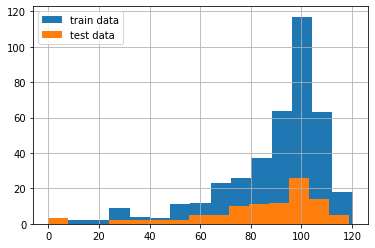

In [8]:
y_train.hist(label='train data',bins=15)
y_test.hist(label='test data',bins=15)
plt.legend(loc='upper left')
plt.show()

In [9]:
from filter_data import Filter

In [10]:
F = Filter(0.01,0.95,None)

In [9]:
print('Train data shape = {}'.format(X_train.shape))

Train data shape = (393, 877)


In [10]:
'''https://datascience.stackexchange.com/questions/31453/how-to-decide-what-threshold-to-use-for-removing-low-variance-features'''
'''https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection'''

def variance_threshold_selector(data, threshold=0.05):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

X_train2   = variance_threshold_selector(X_train)

In [11]:
X_train2.shape

(393, 616)

In [12]:
X_train2

,ABC,ABCGG,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,...,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,Complexity,XLogP
61,5.168527,5.361851,8.762573,3.899712,8.762573,2.887985,2.639270,0.747359,21.881722,2.735215,...,114.104465,5.186567,79,5,28,26,4.111111,2.083333,66,2.0
340,6.791188,6.419894,10.006431,4.566977,10.006431,3.109027,2.849160,0.941664,26.636007,2.959556,...,124.125200,4.965008,82,9,44,47,4.173611,1.916667,120,3.4
416,5.875634,5.566041,9.431148,4.350655,9.431148,2.979741,2.736735,0.783622,22.287836,2.785979,...,112.125200,4.671883,61,7,36,38,3.222222,1.833333,58,3.8
466,2.449490,2.449490,3.464102,3.464102,3.464102,2.178059,1.931852,-0.257812,5.583629,1.395907,...,60.057515,5.004793,9,0,12,9,3.111111,1.000000,10,0.3
59,3.535534,3.535534,6.472136,3.618034,6.472136,2.525424,2.236068,0.111572,11.180340,2.236068,...,68.026215,7.558468,15,0,20,20,1.250000,1.250000,22,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,3.535534,3.869735,6.987918,3.603875,6.987918,2.579830,2.341896,0.340135,12.628860,2.104810,...,88.088815,4.893823,35,3,18,16,3.000000,1.750000,19,1.6
131,3.535534,3.869735,6.987918,3.603875,6.987918,2.579830,2.341896,0.340135,12.628860,2.104810,...,82.078250,5.129891,35,3,18,16,3.000000,1.750000,36,2.9
249,6.791188,6.419894,10.006431,4.566977,10.006431,3.109027,2.849160,0.941664,26.636007,2.959556,...,124.125200,4.965008,82,9,44,47,4.173611,1.916667,120,3.6
152,5.168527,5.361851,8.762573,3.899712,8.762573,2.887985,2.639270,0.747359,21.881722,2.735215,...,112.125200,4.671883,79,5,28,26,4.111111,2.083333,66,3.8


In [13]:
print('categorical columns = {}'.format([col for col in X_train2.columns if X_train2[col].dtype=="O"]))

categorical columns = []


In [14]:
'''https://www.kaggle.com/discdiver/guide-to-scaling-and-standardizing
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py'''

class Scale_pd(BaseEstimator, TransformerMixin):
    '''Robust scaler on pandas dataframes'''
    def __init__(self,scalar):
        self.scalar   = scalar
    def fit(self, X: pd.DataFrame):
        return self
    def transform(self, X:pd.DataFrame):
        return  pd.DataFrame(self.scalar.transform(X),columns = X.columns)
    
scalar   = preprocessing.StandardScaler().fit(X_train2)
sc       = Scale_pd(scalar)
X_train3 = sc.transform(X_train2)

In [15]:
def id_to_text(pipe,id_):
    x   = str(pipe.steps[id_]).split(',')
    if len(x)>2:
        str_ = ','.join(x[1:])
    else:
        str_ = x[1]
    return str_


def plot_pipe_result(pipe):
    
    plt.figure(figsize=(6,5))
    
    '''Pipe predictions'''
    
    y_train_pred = pipe.predict(X_train3)
    y_test_pred  = pipe.predict(sc.transform(X_test[X_train3.columns]))
    
    plt.scatter(y_train,y_train_pred,c='blue',label='Train')
    plt.scatter(y_test,y_test_pred,c='orange',label='Test')
    plt.plot(np.linspace(0,120,20),np.linspace(0,120,20),c='r',label='Expected=Predicted')
    plt.xlabel('Expected')
    plt.ylabel('Predicted')
    map_  =  mae(y_test.values[np.where(y_test!=0)[0]],y_test_pred[np.where(y_test!=0)[0]])
    desc  = 'MAE_train = {}'.format(mae(y_train,y_train_pred)) + '\n' \
            'MAE_test = {}'.format(mae(y_test,y_test_pred)) + '\n' \
            'R2_test = {}'.format(r2_score(y_test,y_test_pred))  + '\n' \
            'MAPE_test = {}'.format(map_)
    plt.figtext(0.5, -0.2,desc, ha="center", fontsize=13, bbox={"facecolor":"none", "alpha":0.0, "pad":5})
    plt.legend()
    desc  = '\n'.join([id_to_text(pipe,x) for x in range(len(pipe))])
    plt.title(desc)
    plt.tight_layout()
    
    return plt.show()

## Correlation analysis

In [17]:
X_train3.head(5)

,ABC,ABCGG,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,...,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,Complexity,XLogP
0,-0.112263,-0.038512,-0.066082,-0.631198,-0.066082,0.039202,0.142492,0.228592,0.030235,0.110128,...,0.272916,0.335485,0.313179,-0.419475,-0.375274,-0.533724,0.321957,0.516109,0.080370,-1.049858
1,0.968807,0.746495,0.442178,1.083716,0.442178,0.797511,0.862979,0.739126,0.552543,0.476859,...,0.703808,-0.044560,0.392228,0.725342,1.097713,0.997324,0.381556,0.074973,1.739535,0.227806
2,0.358835,0.112986,0.207108,0.527756,0.207108,0.353981,0.477057,0.323873,0.074850,0.193113,...,0.187807,-0.547364,-0.161115,0.152933,0.361219,0.341160,-0.525675,-0.145596,-0.165432,0.592853
3,-1.923775,-2.199312,-2.231121,-1.750742,-2.231121,-2.396282,-2.285857,-2.412483,-1.760282,-2.079243,...,-2.051107,0.023684,-1.531298,-1.850495,-1.848262,-1.773144,-0.631629,-2.351277,-1.640245,-2.601307
4,-1.200216,-1.393531,-1.001990,-1.355126,-1.001990,-1.204608,-1.241577,-1.441932,-1.145425,-0.705829,...,-1.708452,4.404065,-1.373200,-1.850495,-1.111768,-0.971166,-2.406359,-1.689572,-1.271541,-1.688690


In [18]:
X_train3.corr(method='pearson').abs()

,ABC,ABCGG,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,...,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,Complexity,XLogP
ABC,1.000000,0.974729,0.951901,0.884172,0.951901,0.971256,0.975022,0.955339,0.947574,0.926822,...,0.954206,0.275962,0.878917,0.902436,0.983393,0.955050,0.316227,0.815484,0.797171,0.615194
ABCGG,0.974729,1.000000,0.911514,0.894548,0.911514,0.971553,0.954648,0.967734,0.912285,0.884689,...,0.971999,0.189185,0.870275,0.903493,0.951394,0.916565,0.465523,0.839823,0.787748,0.642961
SpAbs_A,0.951901,0.911514,1.000000,0.769592,1.000000,0.926880,0.959563,0.923809,0.965096,0.958962,...,0.922021,0.340144,0.892404,0.877167,0.919475,0.897139,0.147832,0.888636,0.723650,0.610009
SpDiam_A,0.884172,0.894548,0.769592,1.000000,0.769592,0.911468,0.836912,0.866116,0.741482,0.759717,...,0.805912,0.180471,0.621355,0.808492,0.899029,0.885253,0.378450,0.588369,0.727380,0.544421
SpAD_A,0.951901,0.911514,1.000000,0.769592,1.000000,0.926880,0.959563,0.923809,0.965096,0.958962,...,0.922021,0.340144,0.892404,0.877167,0.919475,0.897139,0.147832,0.888636,0.723650,0.610009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb2,0.955050,0.916565,0.897139,0.885253,0.897139,0.902488,0.883832,0.847024,0.888339,0.869864,...,0.855230,0.275526,0.770564,0.887286,0.991325,1.000000,0.218043,0.676502,0.825388,0.544437
mZagreb1,0.316227,0.465523,0.147832,0.378450,0.147832,0.329796,0.295738,0.397740,0.236225,0.097058,...,0.487145,0.299155,0.413156,0.460631,0.281625,0.218043,1.000000,0.389364,0.321532,0.342337
mZagreb2,0.815484,0.839823,0.888636,0.588369,0.888636,0.814884,0.869709,0.876794,0.888316,0.840166,...,0.918660,0.193674,0.929426,0.824371,0.732116,0.676502,0.389364,1.000000,0.589730,0.626000
Complexity,0.797171,0.787748,0.723650,0.727380,0.723650,0.743087,0.730733,0.713990,0.745523,0.701539,...,0.736277,0.342393,0.695077,0.751395,0.823355,0.825388,0.321532,0.589730,1.000000,0.285548


ಠ_ಠ😁🤣😍😎

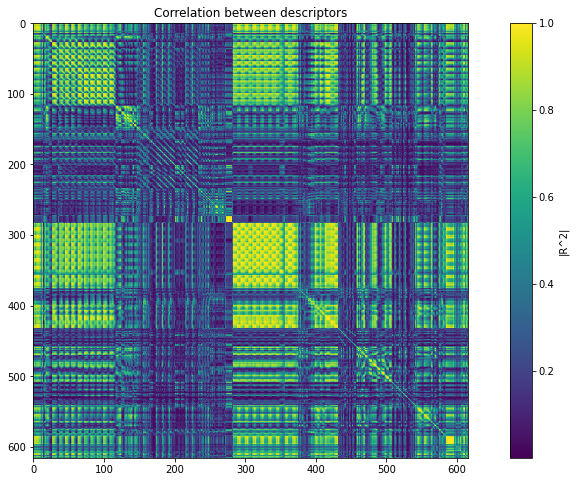

In [16]:
### Plot correlation between 

cor_matrix = X_train3.corr(method='pearson').abs()
plt.figure(figsize=(15,8))
plt.imshow(cor_matrix)
plt.colorbar(label='|R^2|')
plt.title('Correlation between descriptors')
plt.show()

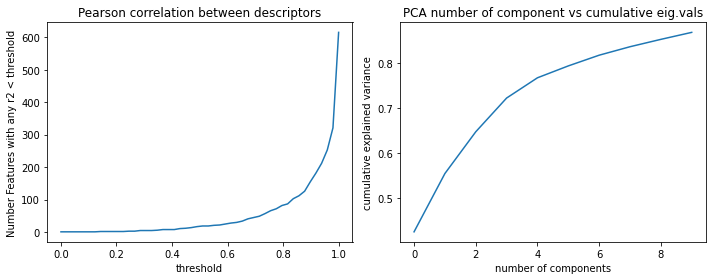

In [65]:
'''https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python'''
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

def n_corr(x):
    '''Input correlation threshold, number of features with any r2>threshold'''
    return len(upper_tri)-len([column for column in upper_tri.columns if any(upper_tri[column] > x)])

range_ = np.linspace(0.,1.,50)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 4))

ax1.plot(range_,[n_corr(x) for x in range_])
ax1.set_xlabel('threshold')
ax1.set_ylabel('Number Features with any r2 < threshold')
ax1.set_title('Pearson correlation between descriptors')


pca = PCA(n_components=10).fit(X_train3)

ax2.plot(np.cumsum(pca.explained_variance_ratio_))
ax2.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance');
ax2.set_title('PCA number of component vs cumulative eig.vals')

fig.tight_layout()


In [73]:
'''Drop columns with correlation higher then 95%'''
col_with_high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]

print('obtained number of features = {}'.format(X_train3.shape[1]-len(col_with_high_corr)))

obtained number of features = 323


In [71]:
X_train3.shape

(393, 616)

In [69]:
## Multicolinear Filter 

cor_matrix         = X_train3.corr(method='pearson').abs()
upper_tri          = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

class DropSomeColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
    def fit(self, X: pd.DataFrame, y: pd.Series):
        return self 
    def transform(self, X:pd.DataFrame):
        cols = [column for column in upper_tri.columns if any(upper_tri[column] > self.threshold)]
        X    = X.copy()
        return X.drop(cols,axis=1)

In [19]:


#pipe         = Pipeline(steps=[('drop',DropSomeColumns()),('pca',PCA()),('r',linear_model.Lasso())])
#search_space = [{'drop__threshold':[0.7,0.85,0.9],'pca__n_components':[10,25,40],'r__alpha':[0.1,0.5,0.7]}]

pipe         = Pipeline(steps=[('drop',DropSomeColumns()),('r',linear_model.Lasso())])

#reg_         = GridSearchCV(pipe, search_space, cv=10, verbose=0,scoring='neg_mean_absolute_error')


In [20]:
pipe = Pipeline(steps=[('drop',DropSomeColumns(threshold=0.9)),('r',MLPRegressor(batch_size=5,hidden_layer_sizes=(100,100),alpha=0.0001,learning_rate_init=0.002,max_iter=600,tol=1.0))])

In [21]:
def objective(trial):
    
    lr    = trial.suggest_float('r__learning_rate_init',10**-5,10**-3,log=True)

    alpha = trial.suggest_float('r__alpha',10**-4,10**-1,log=True)
    
    bz    = trial.suggest_int('r__batch_size',3,10)
    
    pipe.set_params(r__learning_rate_init = lr,r__alpha= alpha, r__batch_size = bz)
    
    score = cross_val_score(pipe,X_train3,y_train,cv=5,scoring='neg_mean_absolute_error').mean()
    
    return score 

In [22]:
study = optuna.create_study(direction="maximize")

[I 2022-03-31 13:11:53,896] A new study created in memory with name: no-name-62695d37-b758-41de-8d90-ba0f4002cc9a


In [23]:
study.optimize(objective, n_trials=100)

[I 2022-03-31 13:12:15,969] Trial 0 finished with value: -7.628141976359788 and parameters: {'r__learning_rate_init': 0.00011557261146570709, 'r__alpha': 0.001126964733078116, 'r__batch_size': 5}. Best is trial 0 with value: -7.628141976359788.
[I 2022-03-31 13:12:52,929] Trial 1 finished with value: -12.575825563605791 and parameters: {'r__learning_rate_init': 2.228036805026105e-05, 'r__alpha': 0.00010042685373422739, 'r__batch_size': 10}. Best is trial 0 with value: -7.628141976359788.
[I 2022-03-31 13:13:04,845] Trial 2 finished with value: -7.981379619791474 and parameters: {'r__learning_rate_init': 0.00017121551147734852, 'r__alpha': 0.07348121502583006, 'r__batch_size': 10}. Best is trial 0 with value: -7.628141976359788.
[I 2022-03-31 13:13:33,243] Trial 3 finished with value: -7.467647709074159 and parameters: {'r__learning_rate_init': 0.00010862248675192157, 'r__alpha': 0.06204767436490168, 'r__batch_size': 3}. Best is trial 3 with value: -7.467647709074159.
[I 2022-03-31 13:1

[I 2022-03-31 13:22:34,991] Trial 32 finished with value: -6.071260655184638 and parameters: {'r__learning_rate_init': 0.000560843560849862, 'r__alpha': 0.03168376955554908, 'r__batch_size': 4}. Best is trial 28 with value: -5.82044202996652.
[I 2022-03-31 13:22:54,581] Trial 33 finished with value: -6.107702064873998 and parameters: {'r__learning_rate_init': 0.0004829187682668247, 'r__alpha': 0.03972571769624624, 'r__batch_size': 3}. Best is trial 28 with value: -5.82044202996652.
[I 2022-03-31 13:23:23,252] Trial 34 finished with value: -8.182895579903652 and parameters: {'r__learning_rate_init': 6.917983890238828e-05, 'r__alpha': 0.01601528564106622, 'r__batch_size': 4}. Best is trial 28 with value: -5.82044202996652.
[I 2022-03-31 13:23:37,814] Trial 35 finished with value: -6.572049535834802 and parameters: {'r__learning_rate_init': 0.0003510264857942224, 'r__alpha': 0.009694795214819108, 'r__batch_size': 5}. Best is trial 28 with value: -5.82044202996652.
[I 2022-03-31 13:24:11,4

[I 2022-03-31 13:32:44,754] Trial 64 finished with value: -5.9816735228382125 and parameters: {'r__learning_rate_init': 0.0008333760972072796, 'r__alpha': 0.00022500076893005488, 'r__batch_size': 5}. Best is trial 41 with value: -5.814782681718715.
[I 2022-03-31 13:33:02,148] Trial 65 finished with value: -6.093458598523744 and parameters: {'r__learning_rate_init': 0.000689856043939409, 'r__alpha': 0.012237650696617999, 'r__batch_size': 5}. Best is trial 41 with value: -5.814782681718715.
[I 2022-03-31 13:33:17,074] Trial 66 finished with value: -6.131132309301809 and parameters: {'r__learning_rate_init': 0.0005716526790714417, 'r__alpha': 0.006454477976142394, 'r__batch_size': 6}. Best is trial 41 with value: -5.814782681718715.
[I 2022-03-31 13:33:34,316] Trial 67 finished with value: -6.605649406723292 and parameters: {'r__learning_rate_init': 0.0002454521624358824, 'r__alpha': 0.01751451921182096, 'r__batch_size': 5}. Best is trial 41 with value: -5.814782681718715.
[I 2022-03-31 1

[I 2022-03-31 13:42:31,547] Trial 96 finished with value: -6.194772369102334 and parameters: {'r__learning_rate_init': 0.00035853606906291165, 'r__alpha': 0.0038131877187288113, 'r__batch_size': 4}. Best is trial 92 with value: -5.760868443162271.
[I 2022-03-31 13:42:47,393] Trial 97 finished with value: -6.1824634246113535 and parameters: {'r__learning_rate_init': 0.0005296633649400042, 'r__alpha': 0.004958986355795266, 'r__batch_size': 5}. Best is trial 92 with value: -5.760868443162271.
[I 2022-03-31 13:43:07,428] Trial 98 finished with value: -6.24739682949044 and parameters: {'r__learning_rate_init': 0.0004101601111280247, 'r__alpha': 0.0030496701735485006, 'r__batch_size': 4}. Best is trial 92 with value: -5.760868443162271.
[I 2022-03-31 13:43:23,940] Trial 99 finished with value: -6.1027933646605526 and parameters: {'r__learning_rate_init': 0.0007150688388507043, 'r__alpha': 0.006881923520646467, 'r__batch_size': 5}. Best is trial 92 with value: -5.760868443162271.


In [24]:
study.best_params

{'r__learning_rate_init': 0.0006484956925488028,
 'r__alpha': 0.005033133305702124,
 'r__batch_size': 5}

In [25]:
pipe.set_params(**study.best_params)

Pipeline(steps=[('drop', DropSomeColumns()),
                ('r',
                 MLPRegressor(alpha=0.005033133305702124, batch_size=5,
                              hidden_layer_sizes=(100, 100),
                              learning_rate_init=0.0006484956925488028,
                              max_iter=600, tol=1.0))])

In [26]:
pipe.fit(X_train3,y_train)

Pipeline(steps=[('drop', DropSomeColumns()),
                ('r',
                 MLPRegressor(alpha=0.005033133305702124, batch_size=5,
                              hidden_layer_sizes=(100, 100),
                              learning_rate_init=0.0006484956925488028,
                              max_iter=600, tol=1.0))])

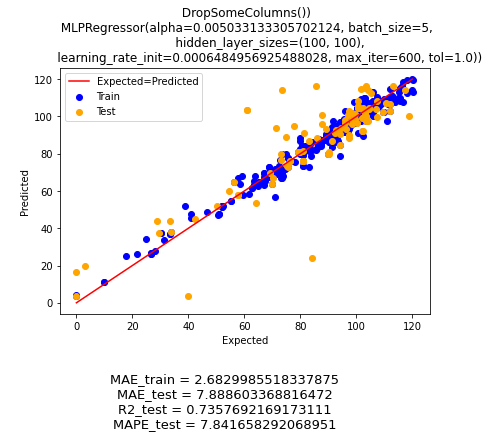

In [27]:
plot_pipe_result(pipe)

In [20]:
def objective(trial):
    
    x = trial.suggest_float('drop__threshold',0.7,0.99)
    
    #y = trial.suggest_int('pca__n_components',10,40)
    
    z = trial.suggest_float('r__alpha',0.1,0.7)
    
    #pipe.set_params(drop__threshold = x, pca__n_components= y, r__alpha = z)
    
    pipe.set_params(drop__threshold = x, r__alpha = z)
    
    score = cross_val_score(pipe,X_train3,y_train,cv=10,scoring='neg_mean_absolute_error').mean()
    
    return score 

In [75]:
study = optuna.create_study(direction="maximize")

[I 2021-08-18 09:54:45,005] A new study created in memory with name: no-name-3d0db730-d72c-4f1d-bcb8-f13639d81ce7


In [76]:
study.optimize(objective, n_trials=100)

[I 2021-08-18 09:54:49,089] Trial 0 finished with value: -9.495171258019234 and parameters: {'drop__threshold': 0.7786383199440872, 'r__alpha': 0.5983427093399165}. Best is trial 0 with value: -9.495171258019234.
[I 2021-08-18 09:54:52,077] Trial 1 finished with value: -8.512447220117222 and parameters: {'drop__threshold': 0.9681979906396934, 'r__alpha': 0.3434623491381763}. Best is trial 1 with value: -8.512447220117222.
[I 2021-08-18 09:54:54,395] Trial 2 finished with value: -9.07869094840094 and parameters: {'drop__threshold': 0.7362259816179346, 'r__alpha': 0.11268994365726026}. Best is trial 1 with value: -8.512447220117222.
[I 2021-08-18 09:54:56,582] Trial 3 finished with value: -9.636815281833556 and parameters: {'drop__threshold': 0.7735779269299546, 'r__alpha': 0.541331880915344}. Best is trial 1 with value: -8.512447220117222.
[I 2021-08-18 09:55:00,767] Trial 4 finished with value: -8.852456976729547 and parameters: {'drop__threshold': 0.9098501030963615, 'r__alpha': 0.435

[I 2021-08-18 09:56:21,728] Trial 27 finished with value: -8.464257558094717 and parameters: {'drop__threshold': 0.9246372705408938, 'r__alpha': 0.20854515160273993}. Best is trial 21 with value: -8.24417629610311.
[I 2021-08-18 09:56:24,036] Trial 28 finished with value: -9.268786567184511 and parameters: {'drop__threshold': 0.8061692426769876, 'r__alpha': 0.29700487738680065}. Best is trial 21 with value: -8.24417629610311.
[I 2021-08-18 09:56:27,448] Trial 29 finished with value: -8.825613342503294 and parameters: {'drop__threshold': 0.889361967227829, 'r__alpha': 0.35698823839671734}. Best is trial 21 with value: -8.24417629610311.
[I 2021-08-18 09:56:30,512] Trial 30 finished with value: -8.345297701985182 and parameters: {'drop__threshold': 0.9425090181204726, 'r__alpha': 0.21519699013315913}. Best is trial 21 with value: -8.24417629610311.
[I 2021-08-18 09:56:33,664] Trial 31 finished with value: -8.296909052503352 and parameters: {'drop__threshold': 0.9699372366173276, 'r__alph

[I 2021-08-18 09:57:25,323] Trial 46 finished with value: -8.2743775819136 and parameters: {'drop__threshold': 0.965973152053154, 'r__alpha': 0.12577205384330514}. Best is trial 32 with value: -8.200628327087234.
C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.897634369146544, tolerance: 16.302193344406778

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.84002533963212, tolerance: 16.772076295395483

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.40975469965269

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.765461507497093, tolerance: 17.54128140183616

[I 2021-08-18 09:59:04,506] Trial 74 finished with value: -8.314826214984862 and parameters: {'drop__threshold': 0.9888278552260663, 'r__alpha': 0.15962787951646823}. Best is trial 63 with value: -8.177852123758663.
[I 2021-08-18 09:59:08,655] Trial 75 finished with value: -8.20958546693387 and parameters: {'drop__threshold': 0.9747817837270122, 'r__alpha': 0.1839587206921293}. Best is trial 63 with value: -8.177852123758663.
[I 2021-08-18 09:59:12,077] Trial 76 finished with value: -8.951983717501081 and parameters: {'drop__threshold': 0.9568620361227397, 'r__alpha': 0.5491193406799175}. Best is trial 63 with value: -8.177852123758663.
[I 2021-08-18 09:59:15,334] Trial 77 finished with value: -8.285044028997358 and p

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.12693621422659, tolerance: 17.54128140183616

[I 2021-08-18 10:00:27,359] Trial 98 finished with value: -8.288049187695735 and parameters: {'drop__threshold': 0.9574032076835415, 'r__alpha': 0.14902004863720306}. Best is trial 63 with value: -8.177852123758663.
C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.413966257725406, tolerance: 17.54128140183616

[I 2021-08-18 10:00:30,800] Trial 99 finished with value: -8.227071181044373 and parameters: {'drop__threshold': 0.9857894386543204, 'r__alpha': 0.16638455231712537}. Best is trial 63 with value: -8.177852123758663.


In [ ]:
from optuna.visualization import plot_parallel_coordinate


In [ ]:
plot_parallel_coordinate(study)

In [59]:
study.best_params

{'r__C': 486.6540337595575, 'r__gamma': 0.05271952338468215, 'r__degree': 7}

In [ ]:
pipe.set_params(**study.best_params)

In [ ]:
pipe.fit(X_train3,y_train)

In [ ]:
plot_pipe_result(pipe)

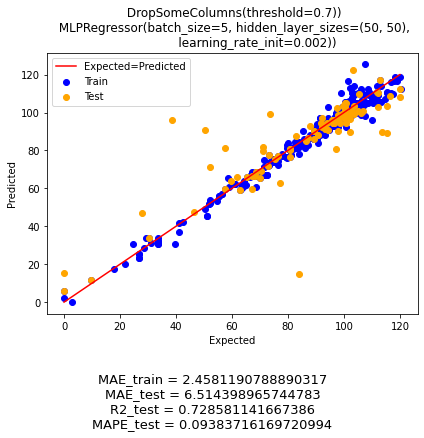

In [123]:
plot_pipe_result(pipe)

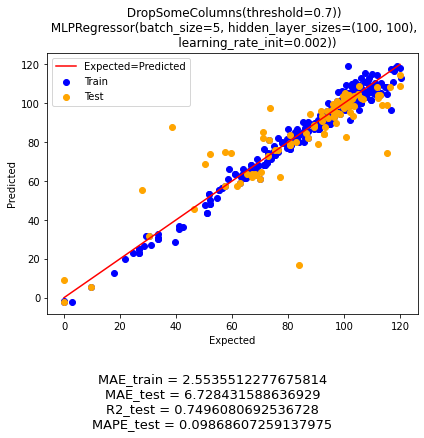

In [127]:
plot_pipe_result(pipe)

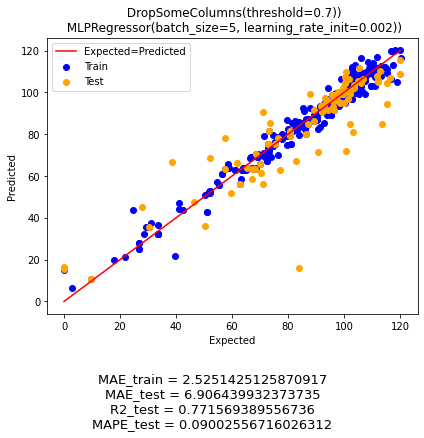

In [115]:
plot_pipe_result(pipe)

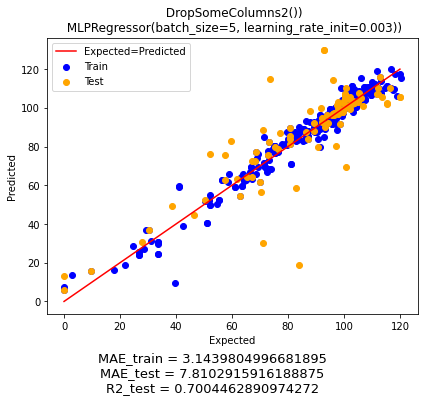

In [256]:
plot_pipe_result(pipe)

In [56]:
# Build step forward feature selection
sfs1 = sfs(SVR(gamma='auto'),
           k_features=50,
           forward=True,
           floating=False,
           verbose=0,
           scoring='neg_mean_squared_error',
           cv=5)

In [57]:
X_train3.shape

(393, 616)

In [58]:
sfs1.fit(X_train3,y_train)

SequentialFeatureSelector(estimator=SVR(gamma='auto'), k_features=50,
                          scoring='neg_mean_squared_error')

In [43]:
model = SVR(gamma='auto')

In [44]:
model.fit(sfs1.transform(X_train3),y_train)

SVR(gamma='auto')

In [45]:
class DropSomeColumns2(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
    def fit(self, X: pd.DataFrame, y: pd.Series):
        return self 
    def transform(self, X:pd.DataFrame):
        sfs1.transform(X)
        return sfs1.transform(X)

In [49]:
def objective(trial):
    
    C       = trial.suggest_float('r__C', 1e-3, 10**3, log=True)
    
    gamma   = trial.suggest_float('r__gamma',1e-3,1e-1,log=True)
    
    degree = trial.suggest_int('r__degree',2,10)
    
    pipe.set_params(r__gamma = gamma, r__C = C,r__degree=degree)
    
    score = cross_val_score(pipe,X_train3,y_train,cv=5,scoring='neg_mean_absolute_error').mean()
    
    return score 

In [50]:
study = optuna.create_study(direction="maximize")

[I 2022-04-03 15:02:57,089] A new study created in memory with name: no-name-075e4002-b16d-40d6-a469-a31c194ade77


In [51]:
study.optimize(objective, n_trials=1000)

[I 2022-04-03 15:02:57,874] Trial 0 finished with value: -12.676008005544272 and parameters: {'r__C': 0.2606225017441344, 'r__gamma': 0.09917933815778576, 'r__degree': 6}. Best is trial 0 with value: -12.676008005544272.
[I 2022-04-03 15:02:57,965] Trial 1 finished with value: -14.78913320929291 and parameters: {'r__C': 0.004179110979058304, 'r__gamma': 0.007240276882588771, 'r__degree': 2}. Best is trial 0 with value: -12.676008005544272.
[I 2022-04-03 15:02:58,056] Trial 2 finished with value: -14.844705371744102 and parameters: {'r__C': 0.0014258537120353028, 'r__gamma': 0.0018840032392612818, 'r__degree': 8}. Best is trial 0 with value: -12.676008005544272.
[I 2022-04-03 15:02:58,248] Trial 3 finished with value: -4.422073771699649 and parameters: {'r__C': 308.1551396461147, 'r__gamma': 0.05083811440482759, 'r__degree': 7}. Best is trial 3 with value: -4.422073771699649.
[I 2022-04-03 15:02:58,314] Trial 4 finished with value: -8.833921431195602 and parameters: {'r__C': 13.72317919

[I 2022-04-03 15:03:08,758] Trial 70 finished with value: -4.4218863291754404 and parameters: {'r__C': 654.1182782532551, 'r__gamma': 0.07537199746947833, 'r__degree': 9}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:08,995] Trial 71 finished with value: -4.4074466358646545 and parameters: {'r__C': 549.1735016788232, 'r__gamma': 0.041471067792558866, 'r__degree': 8}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:09,268] Trial 72 finished with value: -4.402107367841802 and parameters: {'r__C': 750.0887890899663, 'r__gamma': 0.053066069684238194, 'r__degree': 3}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:09,427] Trial 73 finished with value: -4.481920328238711 and parameters: {'r__C': 325.88842625569606, 'r__gamma': 0.0424220524038227, 'r__degree': 3}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:09,565] Trial 74 finished with value: -4.432100740935605 and parameters: {'r__C': 216.4995634847

[I 2022-04-03 15:03:17,462] Trial 105 finished with value: -4.393217667600437 and parameters: {'r__C': 380.3903848178147, 'r__gamma': 0.05349532337398154, 'r__degree': 4}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:17,655] Trial 106 finished with value: -4.667797578793408 and parameters: {'r__C': 206.11604026620935, 'r__gamma': 0.04095692981641735, 'r__degree': 5}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:17,892] Trial 107 finished with value: -4.405966233425975 and parameters: {'r__C': 509.16658569481217, 'r__gamma': 0.06904685900414068, 'r__degree': 10}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:18,203] Trial 108 finished with value: -4.394908426870496 and parameters: {'r__C': 329.3657509935712, 'r__gamma': 0.05995775227599355, 'r__degree': 4}. Best is trial 43 with value: -4.385549094558712.
[I 2022-04-03 15:03:18,389] Trial 109 finished with value: -4.653522524786794 and parameters: {'r__C': 93.0517213

[I 2022-04-03 15:03:25,806] Trial 140 finished with value: -4.714175815553324 and parameters: {'r__C': 106.59867480505186, 'r__gamma': 0.054439677394690994, 'r__degree': 5}. Best is trial 139 with value: -4.384240770610815.
[I 2022-04-03 15:03:25,993] Trial 141 finished with value: -4.412634790201439 and parameters: {'r__C': 443.9770445301632, 'r__gamma': 0.04302143849698625, 'r__degree': 4}. Best is trial 139 with value: -4.384240770610815.
[I 2022-04-03 15:03:26,151] Trial 142 finished with value: -4.421629349586948 and parameters: {'r__C': 328.4475494525224, 'r__gamma': 0.048133810930444915, 'r__degree': 4}. Best is trial 139 with value: -4.384240770610815.
[I 2022-04-03 15:03:26,433] Trial 143 finished with value: -4.404757559263146 and parameters: {'r__C': 767.3938340225942, 'r__gamma': 0.052084523253700915, 'r__degree': 4}. Best is trial 139 with value: -4.384240770610815.
[I 2022-04-03 15:03:26,662] Trial 144 finished with value: -4.422562747165265 and parameters: {'r__C': 244.3

[I 2022-04-03 15:03:40,613] Trial 209 finished with value: -4.385912478003191 and parameters: {'r__C': 429.9865203783938, 'r__gamma': 0.05223973889693315, 'r__degree': 9}. Best is trial 203 with value: -4.381203424093357.
[I 2022-04-03 15:03:40,803] Trial 210 finished with value: -4.3805861699765005 and parameters: {'r__C': 485.34684624448806, 'r__gamma': 0.05291105800315005, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:41,202] Trial 211 finished with value: -4.381285922051655 and parameters: {'r__C': 513.9165609858711, 'r__gamma': 0.05176762478360969, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:41,476] Trial 212 finished with value: -4.393199842322272 and parameters: {'r__C': 514.3819090502271, 'r__gamma': 0.047062831824784074, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:41,711] Trial 213 finished with value: -4.394267783289998 and parameters: {'r__C': 641

[I 2022-04-03 15:03:48,456] Trial 244 finished with value: -4.404059342632476 and parameters: {'r__C': 418.18930116268126, 'r__gamma': 0.04822299779065222, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:48,632] Trial 245 finished with value: -4.403714629071231 and parameters: {'r__C': 675.0729134045878, 'r__gamma': 0.06472928202244765, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:48,787] Trial 246 finished with value: -4.4121719837220805 and parameters: {'r__C': 296.70821002115696, 'r__gamma': 0.05409663676550177, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:48,945] Trial 247 finished with value: -4.400026945475181 and parameters: {'r__C': 492.38598399473153, 'r__gamma': 0.05981586301308081, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:49,171] Trial 248 finished with value: -4.390253983921809 and parameters: {'r__C': 7

[I 2022-04-03 15:03:54,837] Trial 279 finished with value: -6.0861277131371345 and parameters: {'r__C': 9.407581940096978, 'r__gamma': 0.05118160885255887, 'r__degree': 4}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:55,087] Trial 280 finished with value: -4.432220362549595 and parameters: {'r__C': 545.2214980033663, 'r__gamma': 0.03632630633733875, 'r__degree': 4}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:55,269] Trial 281 finished with value: -5.847130016039152 and parameters: {'r__C': 348.5569747339864, 'r__gamma': 0.006818673215429599, 'r__degree': 4}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:55,495] Trial 282 finished with value: -4.385139275871191 and parameters: {'r__C': 698.5333213888682, 'r__gamma': 0.047109414955216505, 'r__degree': 4}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:03:55,703] Trial 283 finished with value: -4.38591710559982 and parameters: {'r__C': 735

[I 2022-04-03 15:04:09,302] Trial 348 finished with value: -4.402761041086213 and parameters: {'r__C': 320.8464540396465, 'r__gamma': 0.06314522637774311, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:09,770] Trial 349 finished with value: -4.4016824389321405 and parameters: {'r__C': 581.8569519906283, 'r__gamma': 0.0547370730161383, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:10,110] Trial 350 finished with value: -4.393766643610645 and parameters: {'r__C': 464.5371419963439, 'r__gamma': 0.04851346677052194, 'r__degree': 7}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:10,376] Trial 351 finished with value: -4.4047740714872665 and parameters: {'r__C': 815.8376293293703, 'r__gamma': 0.05887468592806016, 'r__degree': 4}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:10,670] Trial 352 finished with value: -4.426198252185797 and parameters: {'r__C': 362.

[I 2022-04-03 15:04:17,157] Trial 383 finished with value: -4.400693566575667 and parameters: {'r__C': 464.9765208981958, 'r__gamma': 0.06296890029521639, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:17,285] Trial 384 finished with value: -4.5390669980472556 and parameters: {'r__C': 193.489302636836, 'r__gamma': 0.051062043832372256, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:17,498] Trial 385 finished with value: -4.45428969666799 and parameters: {'r__C': 292.0527184421613, 'r__gamma': 0.04669322985505734, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:17,737] Trial 386 finished with value: -4.397986201342884 and parameters: {'r__C': 608.1663843206817, 'r__gamma': 0.05759524328893683, 'r__degree': 8}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:17,952] Trial 387 finished with value: -4.414262161062045 and parameters: {'r__C': 992.8

[I 2022-04-03 15:04:23,816] Trial 418 finished with value: -4.387752060964748 and parameters: {'r__C': 403.5911528667429, 'r__gamma': 0.05362301777856435, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:23,947] Trial 419 finished with value: -6.238739661786323 and parameters: {'r__C': 638.7219007447018, 'r__gamma': 0.0030208642787218167, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:24,106] Trial 420 finished with value: -4.399460771621071 and parameters: {'r__C': 480.49647552443275, 'r__gamma': 0.06293673115702218, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:24,183] Trial 421 finished with value: -6.831200005622838 and parameters: {'r__C': 3.5835658167603146, 'r__gamma': 0.04418021668872546, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:24,317] Trial 422 finished with value: -4.47905174922608 and parameters: {'r__C': 24

[I 2022-04-03 15:04:30,166] Trial 453 finished with value: -4.416029965529043 and parameters: {'r__C': 377.46323161517756, 'r__gamma': 0.04717246026024905, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:30,400] Trial 454 finished with value: -4.403257277418977 and parameters: {'r__C': 979.3764684507208, 'r__gamma': 0.0561782986876865, 'r__degree': 8}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:30,658] Trial 455 finished with value: -4.399790730301488 and parameters: {'r__C': 634.0044365196331, 'r__gamma': 0.04216077533265009, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:30,849] Trial 456 finished with value: -4.386727900207676 and parameters: {'r__C': 471.6636264226625, 'r__gamma': 0.05025963567821564, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:31,015] Trial 457 finished with value: -4.39663203409404 and parameters: {'r__C': 661.44

[I 2022-04-03 15:04:36,609] Trial 488 finished with value: -4.408707658315102 and parameters: {'r__C': 786.5556166165492, 'r__gamma': 0.07027892412182168, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:36,791] Trial 489 finished with value: -4.387534279654654 and parameters: {'r__C': 535.5996362284072, 'r__gamma': 0.05318722371290066, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:36,963] Trial 490 finished with value: -4.415460416750689 and parameters: {'r__C': 399.75202723122527, 'r__gamma': 0.04528277054005205, 'r__degree': 7}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:37,146] Trial 491 finished with value: -4.422730264975211 and parameters: {'r__C': 526.1834044444552, 'r__gamma': 0.037617017408227704, 'r__degree': 9}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:37,286] Trial 492 finished with value: -5.8193572699634855 and parameters: {'r__C': 28

[I 2022-04-03 15:04:44,358] Trial 523 finished with value: -4.39248951571886 and parameters: {'r__C': 618.8540030806064, 'r__gamma': 0.05127932407510811, 'r__degree': 8}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:44,528] Trial 524 finished with value: -4.408412620205636 and parameters: {'r__C': 467.6956008463082, 'r__gamma': 0.06933600534021499, 'r__degree': 6}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:44,766] Trial 525 finished with value: -4.419070572781298 and parameters: {'r__C': 981.8648702017965, 'r__gamma': 0.04513083970076986, 'r__degree': 8}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:44,920] Trial 526 finished with value: -4.402289054927496 and parameters: {'r__C': 325.4147436376152, 'r__gamma': 0.055019826039149525, 'r__degree': 8}. Best is trial 210 with value: -4.3805861699765005.
[I 2022-04-03 15:04:45,180] Trial 527 finished with value: -4.39545794361287 and parameters: {'r__C': 642.31

[I 2022-04-03 15:04:51,641] Trial 558 finished with value: -4.399263094741934 and parameters: {'r__C': 360.62944129718375, 'r__gamma': 0.0535486521373843, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:51,812] Trial 559 finished with value: -4.399378222519578 and parameters: {'r__C': 480.7245126684934, 'r__gamma': 0.05875131170237361, 'r__degree': 6}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:51,900] Trial 560 finished with value: -13.394236259959635 and parameters: {'r__C': 0.10333154515268775, 'r__gamma': 0.05264755905972135, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:52,064] Trial 561 finished with value: -4.426953237730803 and parameters: {'r__C': 320.3544970993682, 'r__gamma': 0.04671224645733501, 'r__degree': 6}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:52,147] Trial 562 finished with value: -14.475151269107565 and parameters: {'r__C': 0

[I 2022-04-03 15:04:57,751] Trial 593 finished with value: -4.415673287793835 and parameters: {'r__C': 338.07290690505704, 'r__gamma': 0.04976806395271097, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:57,904] Trial 594 finished with value: -4.404058583298509 and parameters: {'r__C': 616.0737248552389, 'r__gamma': 0.06657109801457413, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:58,134] Trial 595 finished with value: -4.387078288717318 and parameters: {'r__C': 426.13664169097007, 'r__gamma': 0.05783900877336009, 'r__degree': 8}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:58,336] Trial 596 finished with value: -4.516801276639467 and parameters: {'r__C': 240.43018373965964, 'r__gamma': 0.047004365562886896, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:04:58,543] Trial 597 finished with value: -4.386562039019849 and parameters: {'r__C': 5

[I 2022-04-03 15:05:04,385] Trial 628 finished with value: -4.4200285921113025 and parameters: {'r__C': 317.6406224110219, 'r__gamma': 0.05065380502766587, 'r__degree': 10}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:04,601] Trial 629 finished with value: -4.413898939504134 and parameters: {'r__C': 421.8193925389166, 'r__gamma': 0.04257565801965491, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:04,747] Trial 630 finished with value: -4.747108960580793 and parameters: {'r__C': 221.03272250896342, 'r__gamma': 0.036100626465539014, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:04,919] Trial 631 finished with value: -4.403643774561841 and parameters: {'r__C': 782.9214610550646, 'r__gamma': 0.06026107520248831, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:05,121] Trial 632 finished with value: -4.410185033806576 and parameters: {'r__C': 5

[I 2022-04-03 15:05:10,747] Trial 663 finished with value: -5.00028071067524 and parameters: {'r__C': 453.6480540980367, 'r__gamma': 0.01792364788247509, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:10,947] Trial 664 finished with value: -6.217017845001751 and parameters: {'r__C': 782.5972898296766, 'r__gamma': 0.0029902994112316573, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:11,143] Trial 665 finished with value: -4.567283741881071 and parameters: {'r__C': 342.03644533880254, 'r__gamma': 0.0379795844644746, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:11,281] Trial 666 finished with value: -4.615229944033745 and parameters: {'r__C': 157.85346677649574, 'r__gamma': 0.05015882240740672, 'r__degree': 10}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:11,436] Trial 667 finished with value: -4.413971863635567 and parameters: {'r__C': 54

[I 2022-04-03 15:05:17,609] Trial 698 finished with value: -5.742678010046732 and parameters: {'r__C': 331.0096495109119, 'r__gamma': 0.007729043926762635, 'r__degree': 2}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:17,853] Trial 699 finished with value: -4.383979011507584 and parameters: {'r__C': 512.7392333413871, 'r__gamma': 0.05342530407504136, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:18,134] Trial 700 finished with value: -4.4196949436427015 and parameters: {'r__C': 996.4009950170906, 'r__gamma': 0.04790201092601753, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:18,253] Trial 701 finished with value: -6.753411653579185 and parameters: {'r__C': 401.4441216135191, 'r__gamma': 0.0017396233843741016, 'r__degree': 5}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:18,431] Trial 702 finished with value: -4.394860265464327 and parameters: {'r__C': 6

[I 2022-04-03 15:05:24,175] Trial 733 finished with value: -4.397965617375547 and parameters: {'r__C': 524.1542087885932, 'r__gamma': 0.060125420641709844, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:24,371] Trial 734 finished with value: -4.383182986431488 and parameters: {'r__C': 650.5058319701968, 'r__gamma': 0.047829152102248175, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:24,516] Trial 735 finished with value: -4.4154393612391285 and parameters: {'r__C': 406.40899875870826, 'r__gamma': 0.06941726876830266, 'r__degree': 10}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:24,749] Trial 736 finished with value: -4.4137681448912875 and parameters: {'r__C': 522.5195940803239, 'r__gamma': 0.041362540174959, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:24,880] Trial 737 finished with value: -7.408972393852798 and parameters: {'r__C': 2

[I 2022-04-03 15:05:30,850] Trial 768 finished with value: -4.405747777748482 and parameters: {'r__C': 797.0734058559093, 'r__gamma': 0.03976773282774085, 'r__degree': 4}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:31,067] Trial 769 finished with value: -4.401678324041915 and parameters: {'r__C': 590.3892476781865, 'r__gamma': 0.05474979848914587, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:31,264] Trial 770 finished with value: -4.401410708693467 and parameters: {'r__C': 437.89065705461996, 'r__gamma': 0.0478032928491638, 'r__degree': 8}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:31,352] Trial 771 finished with value: -14.4323846134541 and parameters: {'r__C': 0.03031618825726274, 'r__gamma': 0.06049880623440569, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:31,506] Trial 772 finished with value: -4.449977870425682 and parameters: {'r__C': 242.

[I 2022-04-03 15:05:37,503] Trial 803 finished with value: -4.430701037086793 and parameters: {'r__C': 791.420055867094, 'r__gamma': 0.03593834148909043, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:37,595] Trial 804 finished with value: -9.497404341220939 and parameters: {'r__C': 0.7208672847748928, 'r__gamma': 0.05066296962839441, 'r__degree': 4}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:37,791] Trial 805 finished with value: -4.523375870154517 and parameters: {'r__C': 314.8366354577435, 'r__gamma': 0.04104739320263809, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:38,026] Trial 806 finished with value: -4.384651953760915 and parameters: {'r__C': 503.1295785158922, 'r__gamma': 0.05411012617477338, 'r__degree': 8}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:38,209] Trial 807 finished with value: -4.412804391554037 and parameters: {'r__C': 695.2

[I 2022-04-03 15:05:44,296] Trial 838 finished with value: -4.382819285332141 and parameters: {'r__C': 596.0085005522947, 'r__gamma': 0.04927645540260852, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:44,520] Trial 839 finished with value: -4.3878484394058965 and parameters: {'r__C': 780.2345689570461, 'r__gamma': 0.04393965095782297, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:44,757] Trial 840 finished with value: -4.419148207068225 and parameters: {'r__C': 981.896832518867, 'r__gamma': 0.047232552042018906, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:45,043] Trial 841 finished with value: -4.414123273075404 and parameters: {'r__C': 622.4055296038247, 'r__gamma': 0.039365990623742436, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:45,294] Trial 842 finished with value: -4.394888986701942 and parameters: {'r__C': 675

[I 2022-04-03 15:05:51,619] Trial 873 finished with value: -4.3952149865434755 and parameters: {'r__C': 649.6042669076106, 'r__gamma': 0.059315520178319245, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:51,756] Trial 874 finished with value: -4.711380183363988 and parameters: {'r__C': 168.6713100384399, 'r__gamma': 0.04219140580911223, 'r__degree': 10}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:51,927] Trial 875 finished with value: -4.405138125203245 and parameters: {'r__C': 351.2083388545803, 'r__gamma': 0.051955811126453165, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:52,089] Trial 876 finished with value: -4.435782340344308 and parameters: {'r__C': 257.18191960535063, 'r__gamma': 0.06912392203099645, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:52,338] Trial 877 finished with value: -4.3983212556975655 and parameters: {'r__C':

[I 2022-04-03 15:05:58,389] Trial 908 finished with value: -4.387076878342982 and parameters: {'r__C': 405.3447324287092, 'r__gamma': 0.053792881581113935, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:58,573] Trial 909 finished with value: -4.395161246504762 and parameters: {'r__C': 577.9713323700461, 'r__gamma': 0.06063128310741085, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:58,794] Trial 910 finished with value: -4.407821381699071 and parameters: {'r__C': 815.3391874556723, 'r__gamma': 0.04766978394151438, 'r__degree': 8}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:58,988] Trial 911 finished with value: -5.150833835793309 and parameters: {'r__C': 433.5192386051644, 'r__gamma': 0.014640670109454332, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:05:59,118] Trial 912 finished with value: -4.824607169781255 and parameters: {'r__C': 128

[I 2022-04-03 15:06:05,045] Trial 943 finished with value: -4.402903567555358 and parameters: {'r__C': 811.3395919794013, 'r__gamma': 0.06054017309844108, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:05,304] Trial 944 finished with value: -5.0268898871993235 and parameters: {'r__C': 450.4974667440197, 'r__gamma': 0.01727847815274255, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:05,451] Trial 945 finished with value: -5.860085428312829 and parameters: {'r__C': 311.7456365105748, 'r__gamma': 0.0069605107257131055, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:05,650] Trial 946 finished with value: -4.432331051135147 and parameters: {'r__C': 521.4241695578751, 'r__gamma': 0.0367468196750178, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:05,903] Trial 947 finished with value: -4.394744037349534 and parameters: {'r__C': 620

[I 2022-04-03 15:06:11,808] Trial 978 finished with value: -4.673849979292067 and parameters: {'r__C': 191.26790258029814, 'r__gamma': 0.041904237852200925, 'r__degree': 7}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:11,999] Trial 979 finished with value: -4.40262524545564 and parameters: {'r__C': 434.4588267734081, 'r__gamma': 0.047578052447876974, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:12,242] Trial 980 finished with value: -4.398472397274449 and parameters: {'r__C': 565.0414603077401, 'r__gamma': 0.05873638590630726, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:12,377] Trial 981 finished with value: -14.833693037180122 and parameters: {'r__C': 0.003223470248148342, 'r__gamma': 0.0019983512867357833, 'r__degree': 9}. Best is trial 554 with value: -4.3804625562607695.
[I 2022-04-03 15:06:12,549] Trial 982 finished with value: -5.568998645427643 and parameters: {'r__C

In [60]:
pipe = Pipeline(steps=[('drop',DropSomeColumns2()),('r',SVR())])

In [61]:
pipe.set_params(**study.best_params)

Pipeline(steps=[('drop', DropSomeColumns2()),
                ('r',
                 SVR(C=486.6540337595575, degree=7,
                     gamma=0.05271952338468215))])

In [62]:
pipe.fit(X_train3,y_train)

Pipeline(steps=[('drop', DropSomeColumns2()),
                ('r',
                 SVR(C=486.6540337595575, degree=7,
                     gamma=0.05271952338468215))])

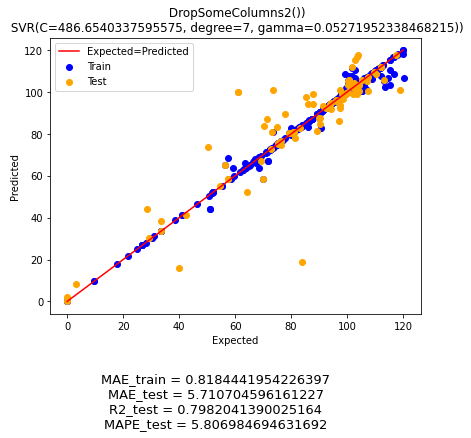

In [63]:
plot_pipe_result(pipe) #50 features

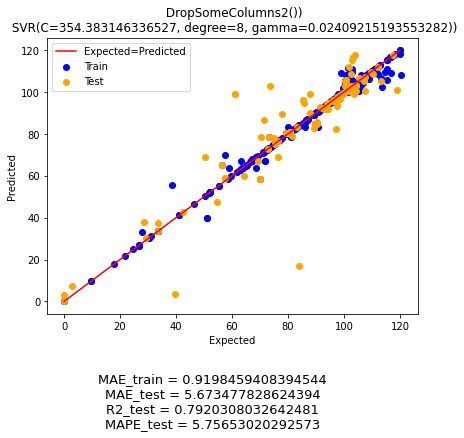

In [82]:
plot_pipe_result(pipe)#100features

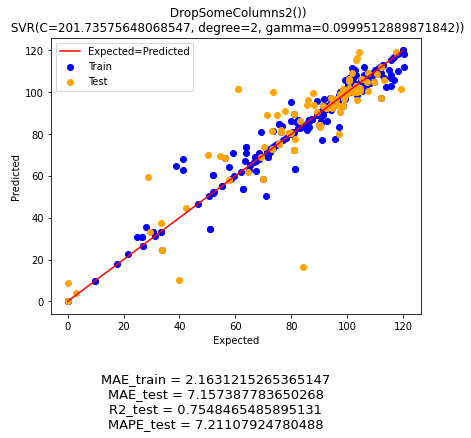

In [44]:
plot_pipe_result(pipe) #15 features

In [45]:
y_test_pred  = pipe.predict(sc.transform(X_test[X_train3.columns]))

(array([47., 18., 14.,  6.,  4.,  4.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.09963273,  3.47987382,  6.86011491, 10.240356  , 13.6205971 ,
        17.00083819, 20.38107928, 23.76132037, 27.14156146, 30.52180256,
        33.90204365, 37.28228474, 40.66252583, 44.04276693, 47.42300802,
        50.80324911, 54.1834902 , 57.56373129, 60.94397239, 64.32421348,
        67.70445457]),
 <BarContainer object of 20 artists>)

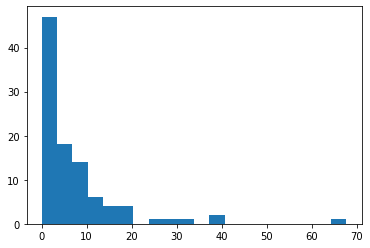

In [46]:
plt.hist(np.abs(y_test_pred-y_test.values),bins=20)

In [47]:
(y_test == 0).sum()

2

In [48]:
np.where(np.abs(y_test_pred-y_test.values)>10)[0]

array([ 2,  9, 17, 29, 33, 36, 38, 41, 42, 50, 51, 55, 57, 66, 72, 76, 84,
       88, 91, 95, 96], dtype=int64)

In [98]:
len(y_test)

99

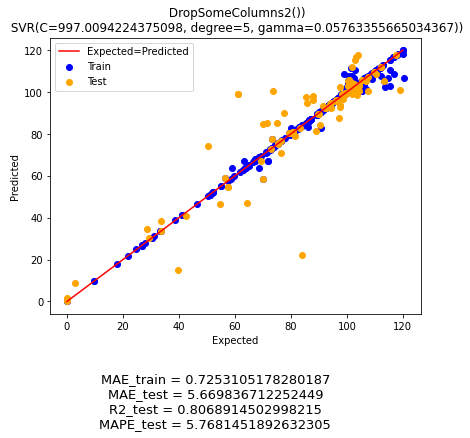

In [70]:
plot_pipe_result(pipe)

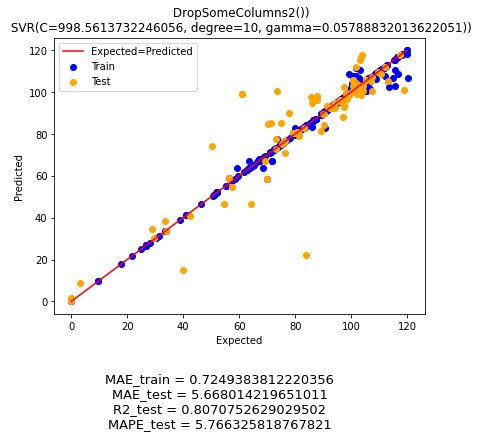

In [32]:
plot_pipe_result(pipe)

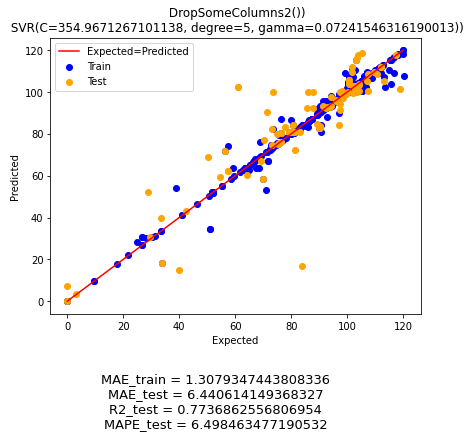

In [60]:
plot_pipe_result(pipe)

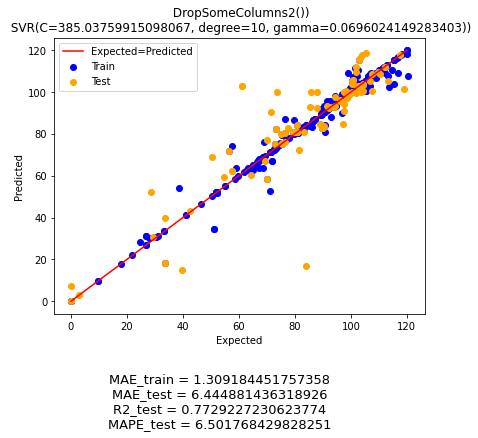

In [52]:
plot_pipe_result(pipe)

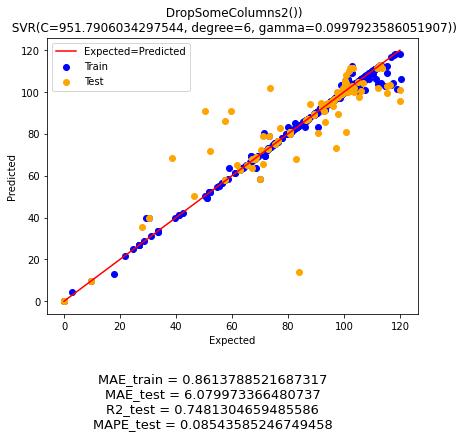

In [131]:
plot_pipe_result(pipe)